In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

SUBONTOLOGIES = ['BPO', 'MFO', 'CCO']
SUBONTOLOGIES_LABELS = {
    'BPO': 'Biological Process',
    'MFO': 'Molecular Function',
    'CCO': 'Cellular Component'
}
SUBONTOLOGIES_COLORS = {
    'BPO': 'forestgreen',
    'MFO': 'tomato',
    'CCO': 'steelblue'
}
DATASETS = ['H30', 'ATGO', 'D1']
SWISSPROT_VERSIONS=[
    "1.0", "4.0", "7.0", "10.0", "13.0", "15.0",
    "2010_01", "2011_01", "2012_01", "2013_01", "2014_01", "2015_01",
    "2016_01", "2017_01", "2018_01", "2019_01", "2020_01", "2021_01",
    "2022_01", "2022_04", "2023_01", "2024_01"
]

def load_test(dataset, aspect):
    """Load data from the specified dataset and aspect."""
    file_path = f"../data/{dataset}/{dataset}_{aspect}_test_annotations.tsv"
    return pd.read_csv(file_path, sep='\t')

def load_train(dataset, aspect, db_version=None):
    """Load training data from the specified dataset, aspect, and SwissProt version."""
    if db_version is None:
        file_path = f"../data/{dataset}/{dataset}_{aspect}_train_annotations.tsv"
    else:
        # Like /home/atoffano/PFP_baselines/data/swissprot/2024_01/swissprot_2024_01_BPO_annotations.tsv
        file_path = f"../data/swissprot/{db_version}/swissprot_{db_version}_{aspect}_annotations.tsv"
    return pd.read_csv(file_path, sep='\t')

# GO Annotations per Protein of Test Datasets

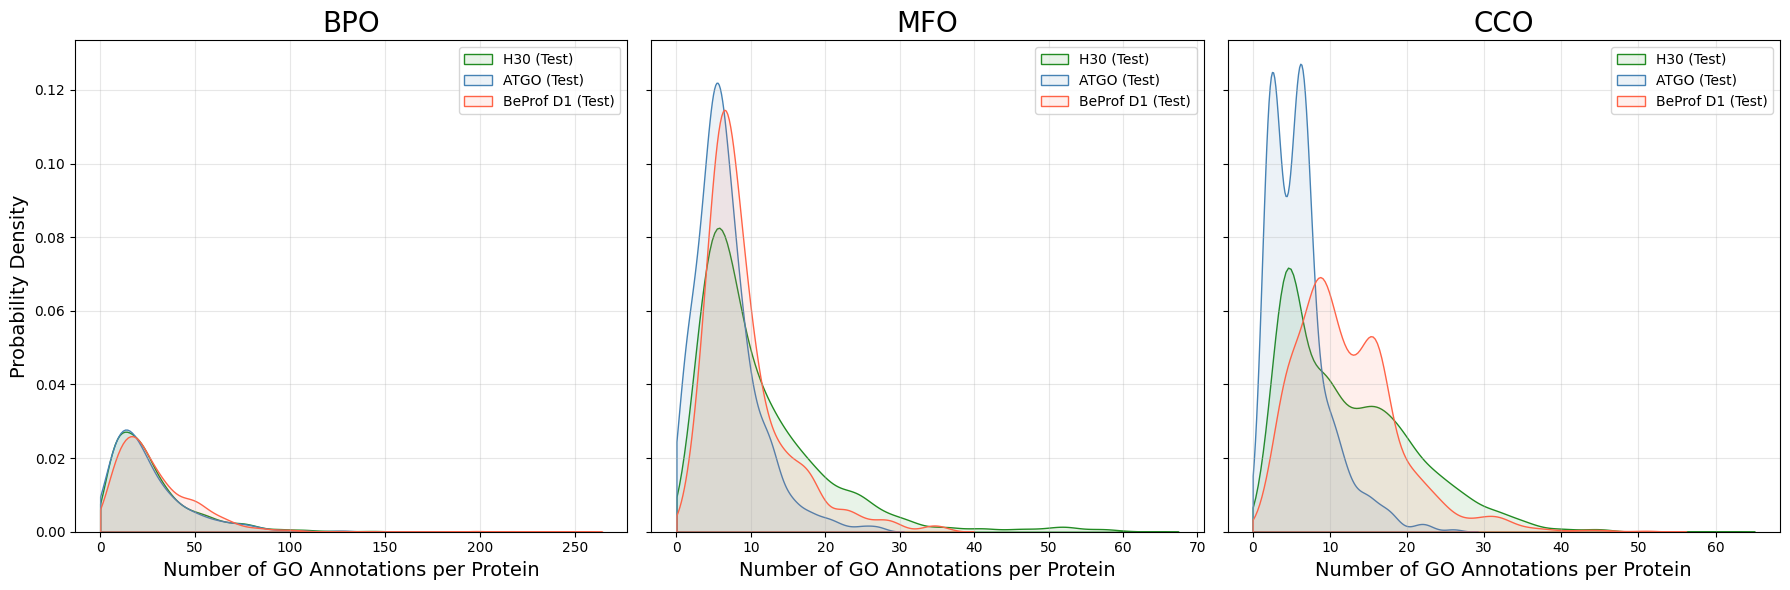

In [4]:
swissprot_test_color = 'forestgreen'  # SwissProt H30 (Test)
test_beprof_color = 'tomato'          # BeProf D1 (Test)
test_atgo_color = 'steelblue'         # ATGO (Test)

fig, axs = plt.subplots(1, len(SUBONTOLOGIES), figsize=(18, 6), sharey=True)

if len(SUBONTOLOGIES) == 1:
    axs = [axs]

for col, aspect in enumerate(SUBONTOLOGIES):
    for dataset in DATASETS:
        # Load and process data
        df = load_test(dataset, aspect)
        df['term'] = df['term'].str.split('; ')
        df = df.explode('term')
        counts = df.groupby('EntryID')['term'].count().reset_index(name='annotation_count')

        # Determine color and label based on dataset
        match dataset:
            case 'H30':
                color = swissprot_test_color
                label = 'H30 (Test)'
            case 'ATGO':
                color = test_atgo_color
                label = 'ATGO (Test)'
            case 'D1':
                color = test_beprof_color
                label = 'BeProf D1 (Test)'

        ann_counts = counts['annotation_count'].clip(lower=0)

        sns.kdeplot(
            ann_counts, fill=True, alpha=0.1,
            color=color, label=label, common_norm=False, clip=(0, None), ax=axs[col]
        )

    axs[col].set_title(f"{aspect}", fontsize=20)
    axs[col].set_xlabel('Number of GO Annotations per Protein', fontsize=14)
    axs[col].grid(alpha=0.3)
    axs[col].legend(fontsize=10)
    if col == 0:
        axs[col].set_ylabel('Probability Density', fontsize=14)

plt.tight_layout()
plt.show()

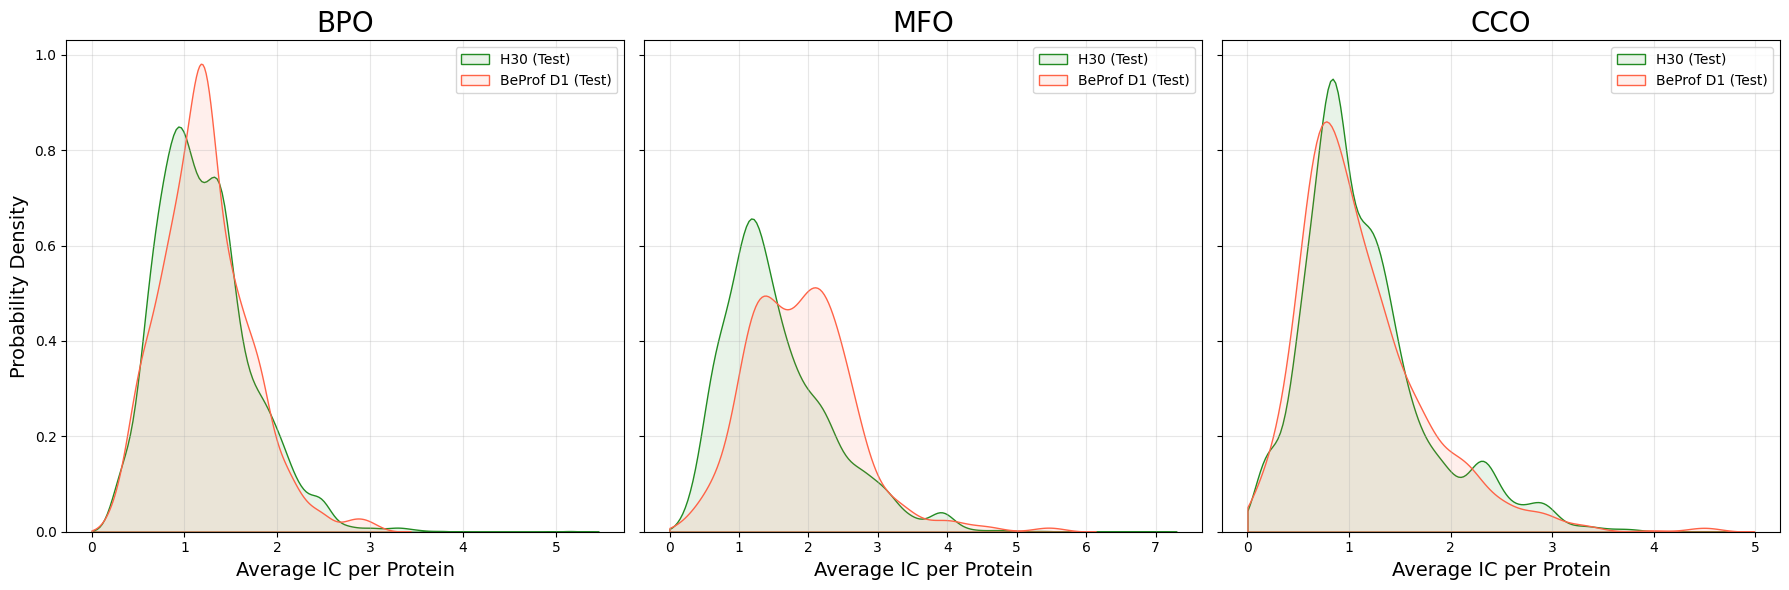

In [5]:
# Load IC values for each term (example for BPO, repeat for other aspects)
ic_files = {
    aspect: f"/home/atoffano/PFP_baselines/data/H30/IC_H30_{aspect}.tsv"
    for aspect in SUBONTOLOGIES
}
ic_dicts = {}
for aspect in SUBONTOLOGIES:
    ic_df = pd.read_csv(ic_files[aspect], sep='\t', names=['term', 'IC'])
    ic_dicts[aspect] = dict(zip(ic_df['term'], ic_df['IC']))

fig, axs = plt.subplots(1, len(SUBONTOLOGIES), figsize=(18, 6), sharey=True)

if len(SUBONTOLOGIES) == 1:
    axs = [axs]

for col, aspect in enumerate(SUBONTOLOGIES):
    ic_dict = ic_dicts[aspect]
    for dataset in ['H30', 'D1']:  # Exclude ATGO
        df = load_test(dataset, aspect)
        df['term'] = df['term'].str.split('; ')
        df = df.explode('term')
        # Map IC values
        df['IC'] = df['term'].map(ic_dict)
        avg_ic = df.groupby('EntryID')['IC'].mean().dropna()

        # Determine color and label based on dataset
        match dataset:
            case 'H30':
                color = swissprot_test_color
                label = 'H30 (Test)'
            case 'D1':
                color = test_beprof_color
                label = 'BeProf D1 (Test)'

        sns.kdeplot(
            avg_ic, fill=True, alpha=0.1,
            color=color, label=label, common_norm=False, clip=(0, None), ax=axs[col]
        )

    axs[col].set_title(f"{aspect}", fontsize=20)
    axs[col].set_xlabel('Average IC per Protein', fontsize=14)
    axs[col].grid(alpha=0.3)
    axs[col].legend(fontsize=10)
    if col == 0:
        axs[col].set_ylabel('Probability Density', fontsize=14)

plt.tight_layout()
plt.show()